In [1]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap


from collections import OrderedDict
from itertools import combinations
import matplotlib.pyplot as plt
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import pickle
import os

import seaborn as sns

In [2]:
pd.__version__

'1.4.0'

In [3]:
with open("../variable_parameters.pickle", "rb") as f:
    variable_params = pickle.load(f)

In [4]:
problem = {
    'num_vars': 3,
    'names': ['forager_royal_ratio', 'growth_factor', "resource_variability"],
    'bounds': [[0.0, 1.0], [0.0, 1.0], [0.0, 0.5]]
}

In [5]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

data_9.pickle
data_5.pickle
data_7.pickle
data_3.pickle
data_1.pickle
data_8.pickle
data_4.pickle
data_6.pickle
data_2.pickle
data_0.pickle
                            ST   ST_conf
forager_royal_ratio   0.327670  0.018311
growth_factor         0.498712  0.026600
resource_variability  0.702669  0.028654
                            S1   S1_conf
forager_royal_ratio   0.103363  0.017508
growth_factor        -0.026167  0.013521
resource_variability -0.332209  0.020623


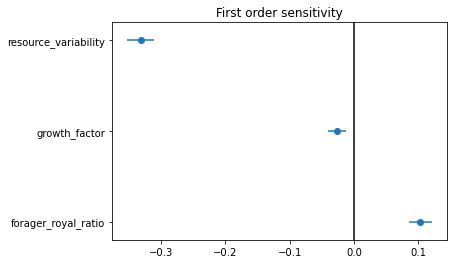

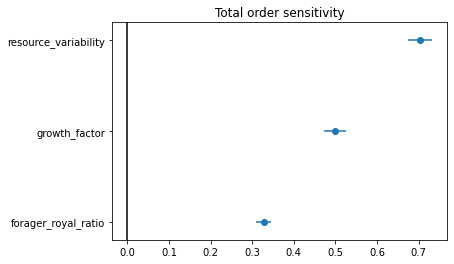

In [6]:
combined = OrderedDict()
for item in variable_params:
    key = (item["forager_royal_ratio"], item["growth_factor"], item["resource_variability"])
    combined[key] = []

for file in os.listdir():
    if "data_" in file and ".pickle" in file:
        with open(file, "rb") as f:
            data = pickle.load(f)
        
        print(file)
        for key, row in data.items():
            parameters = (key[0], key[1], key[2])
            if parameters in combined:
                combined[parameters].append(row)
            else:
                combined[parameters] = row

aggregated = {"forager_royal_ratio":[], "growth_factor":[], 
              "resource_variability":[], "Total Fertilized Queens":[]}

for key, rows in combined.items():
    for row in rows:
        aggregated["forager_royal_ratio"].append(key[0])
        aggregated["growth_factor"].append(key[1])
        aggregated["resource_variability"].append(key[2])
        aggregated["Total Fertilized Queens"].append(row["Total Fertilized Queens"][0])

final_dataframe = pd.DataFrame.from_dict(aggregated)

Si = sobol.analyze(problem, np.array(final_dataframe['Total Fertilized Queens']), 
                                     print_to_console=True, calc_second_order=False)

# for i, first_index in enumerate(Si['S1']):
#     if first_index < 0:
#         Si['S1'][i]= 0
#         Si['S1_conf'] = 0
    
plot_index(Si, problem['names'], '1', 'First order sensitivity')
plt.savefig("first_order_sa.pdf", dpi=200, bbox_inches="tight")
plt.show()

plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
plt.savefig("total_order_sa.pdf", dpi=200, bbox_inches="tight")
plt.show()




# Results

In [7]:
# for each unique param combination : take avg and stdev

# divide resource_var in 3 bins - rank strategies to find best in each category, best overall

In [8]:
avg_std = {}
for key, rows in combined.items():
    values = [rows[i]["Total Fertilized Queens"][0] for i in range(len(rows))]
    avg_std[key] = {"mean":np.mean(values), "std":np.std(values)}

In [9]:
def find_best_strategy(min_resource_variability, max_resource_variability, top_strategies=1):
    
    best_val = -1
#     best_strategy = None
    best_strategies_vals = []
    
    for key, item in avg_std.items():
        if min_resource_variability <= key[-1] <= max_resource_variability:
            best_strategies_vals.append([key, item["mean"]])
    best_strategies_vals = sorted(best_strategies_vals, key=lambda x: x[1], reverse=True)
    
    best_strategies, best_vals = [], []
    for i in range(top_strategies):
        best_strategies.append(best_strategies_vals[i][0])
        best_vals.append(best_strategies_vals[i][1])
    
    return best_strategies, best_vals

#             if item["mean"] > best_val:
#                 best_strategy = key
#                 best_val = item["mean"]
                
#     return best_strategy, best_val

In [10]:
for key in combined:
    if key[2] < 0.1:
        if  0.15 < key[1] <= 0.20:
            if key[0] <= 0.05:
                print(key)

In [11]:
grouped_by_stragegy = {}
for key, item in avg_std.items():
    strategy = (key[0], key[1])
    if strategy not in grouped_by_stragegy:
        grouped_by_stragegy[strategy] = {}
    for row in rows:
        grouped_by_stragegy[strategy][key[2]] = item["mean"]

In [12]:
bin_count = 10
bins = {(i,j):{} for i in range(bin_count) for j in range(bin_count)}

for key, stuff in grouped_by_stragegy.items():
    bin_location = (int(key[0]*bin_count), int(key[1]*bin_count))
    for resouce_var in stuff:
        if resouce_var not in bins[bin_location]:
            bins[bin_location][resouce_var] = []
        bins[bin_location][resouce_var].append(stuff[resouce_var])

In [13]:
bin_ranges = [(0.0, 0.1), (0.1, 0.4), (0.4, 0.5)]

performance = {r:[] for r in bin_ranges}

for b, dictionary in bins.items():
    p = {bin_ranges[0]:[], bin_ranges[1]:[], bin_ranges[2]:[]}
    for resource_var, performance_list in dictionary.items():
        if 0 < resource_var <= bin_ranges[0][1]:
            p[bin_ranges[0]] += performance_list
        elif bin_ranges[1][0] < resource_var <= bin_ranges[1][1]:
            p[bin_ranges[1]] += performance_list
        else:
            p[bin_ranges[2]] += performance_list
    for key in p:
        performance[key].append((b, np.mean(p[key])))

In [14]:
# print best strategies for different resource variabilities
for k in performance:
    print(f"Resource Variability Range : {k}")
    temp =list(sorted(performance[k], key=lambda x:x[1], reverse=True))[:5]
    for item in temp:
        print(item)
    print()

Resource Variability Range : (0.0, 0.1)
((5, 9), 834.8499999999999)
((5, 8), 824.9499999999999)
((4, 9), 822.2500000000001)
((5, 7), 814.0333333333333)
((6, 9), 809.46)

Resource Variability Range : (0.1, 0.4)
((5, 9), 808.6785714285713)
((5, 7), 805.2900000000001)
((6, 8), 803.6692307692307)
((5, 8), 801.9100000000001)
((6, 9), 800.2769230769229)

Resource Variability Range : (0.4, 0.5)
((4, 4), 740.9333333333333)
((7, 8), 737.8333333333334)
((5, 8), 737.8)
((4, 6), 736.68)
((6, 7), 730.2666666666668)



In [15]:
# create a colormap for the heatmap

def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb =matplotlib.colors.hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

hc = ['#160c06', "#d09005", '#fbd604']
th = [0, 0.9, 1]

cdict = NonLinCdict(th, hc)
cm = LinearSegmentedColormap('test', cdict)

In [16]:
# this can be used to test that values in the heatmap are in the correct places
[mean for point, mean in performance[(0.0,0.1)] if point==(7,3)] 

[699.825]

Resource Variability Range : (0.0, 0.1)
Resource Variability Range : (0.1, 0.4)
Resource Variability Range : (0.4, 0.5)


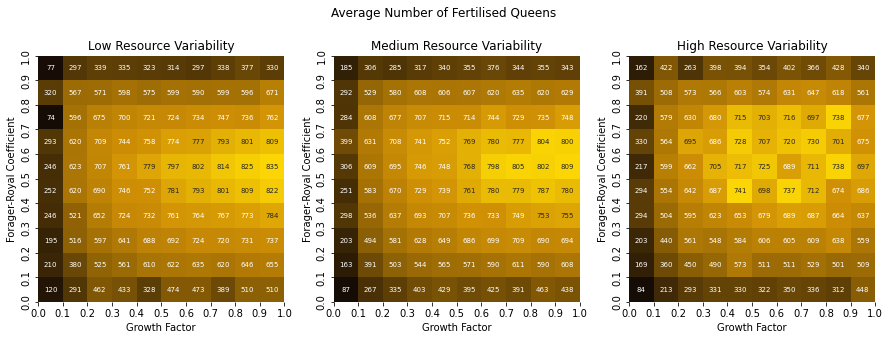

In [17]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
pretty_text = {bin_ranges[0]: 'Low', bin_ranges[1]: 'Medium', bin_ranges[2]: 'High'}

for i, (resource_variability_category, values) in enumerate(performance.items()):
    print(f"Resource Variability Range : {resource_variability_category}")

    # (forager_royal_ratio, growth_factor)
    # generate matrix with forager_royal_ratio as rows and growth_factor as columns
    # for the vertical axis, we want 0 to be at the bottom and 1 at the top
    rows = []
    for j in range(bin_count):
        rows.append([mean for point, mean in values if point[0] == (bin_count-1)-j])
    matrix = np.array(np.vstack(rows))

    g = sns.heatmap(matrix, cmap=cm, annot=True, fmt='.0f', square=True, annot_kws={"size": 7}, ax=axs[i], cbar=False)
    g.set_title(f"{pretty_text[resource_variability_category]} Resource Variability")
    g.set_xlabel("Growth Factor")
    g.set_ylabel("Forager-Royal Coefficient")
    g.set_yticks(np.linspace(bin_count, 0, bin_count+1, endpoint=True))
    g.set_yticklabels([format(y, '.1f') for y in np.linspace(0, 1, bin_count+1, endpoint=True)])
    g.set_xticks(np.linspace(0, bin_count, bin_count+1, endpoint=True))
    g.set_xticklabels([format(x, '.1f') for x in np.linspace(0, 1, bin_count+1, endpoint=True)])
plt.suptitle('Average Number of Fertilised Queens')
plt.savefig(f'rq_results.pdf')
plt.show()

In [18]:
find_best_strategy(bin_ranges[0][0], bin_ranges[0][1], top_strategies=10)

([(0.4462890625, 0.9794921875, 0.06787109375),
  (0.5947265625, 0.9248046875, 0.09619140625),
  (0.5419921875, 0.8837890625, 0.03564453125),
  (0.5478515625, 0.9912109375, 0.06201171875),
  (0.4814453125, 0.8779296875, 0.03076171875),
  (0.5810546875, 0.9853515625, 0.00927734375),
  (0.5673828125, 0.7021484375, 0.03955078125),
  (0.5556640625, 0.9443359375, 0.07568359375),
  (0.4912109375, 0.9580078125, 0.03271484375),
  (0.5244140625, 0.8857421875, 0.05322265625)],
 [848.4, 845.5, 841.4, 836.3, 830.2, 830.1, 828.4, 827.5, 827.1, 826.6])

In [68]:
with open("50_runs_bestOverall_low.pickle", "rb") as f:
    best = pickle.load(f)

In [69]:
final_df = best[0]
for i in best:
  final_df = pd.concat([final_df, i], ignore_index=True)



In [70]:
dict = {}

for key, value in final_df.items() :
  mean = final_df[f'{key}'].mean()
  confidence_int = final_df[f'{key}'].std()/len(final_df[f'{key}'])**0.5
  dict[f'{key}:mean'] = mean
  dict[f'{key}:c.i.'] = confidence_int



In [71]:
dict

{'Total Workers:mean': 213.11764705882354,
 'Total Workers:c.i.': 5.087520067605921,
 'Total Queens:mean': 125.15686274509804,
 'Total Queens:c.i.': 2.83125033683341,
 'Total Drones:mean': 119.01960784313725,
 'Total Drones:c.i.': 2.995354598940641,
 'Total Fertilized Queens:mean': 889.2549019607843,
 'Total Fertilized Queens:c.i.': 27.291496099029402,
 'Workers in Hive 0:mean': 65.0,
 'Workers in Hive 0:c.i.': 7.049238590506236,
 'Queens in Hive 0:mean': 38.72549019607843,
 'Queens in Hive 0:c.i.': 3.9596076683619827,
 'Drones in Hive 0:mean': 37.03921568627451,
 'Drones in Hive 0:c.i.': 3.9233799738324584,
 'Workers in Hive 1:mean': 86.96078431372548,
 'Workers in Hive 1:c.i.': 8.92157379874877,
 'Queens in Hive 1:mean': 49.96078431372549,
 'Queens in Hive 1:c.i.': 4.648420417717604,
 'Drones in Hive 1:mean': 47.05882352941177,
 'Drones in Hive 1:c.i.': 4.459878813504002,
 'Workers in Hive 2:mean': 61.15686274509804,
 'Workers in Hive 2:c.i.': 8.237712063336929,
 'Queens in Hive 2:me